<a href="https://colab.research.google.com/github/gabrieldilay/TitanicAnaliseSupervisionada/blob/main/TitanicSupervisionado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [352]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [353]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [354]:
titanic_train_df = pd.read_csv('/content/drive/MyDrive/Trab Supervisionado/train.csv',
                      sep=',', encoding='iso-8859-1')
titanic_test_df = pd.read_csv('/content/drive/MyDrive/Trab Supervisionado/test.csv',
                      sep=',', encoding='iso-8859-1')
titanic_test_df_y = pd.read_csv('/content/drive/MyDrive/Trab Supervisionado/gender_submission.csv',
                      sep=',', encoding='iso-8859-1')
titanic_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Tratamento de Dados

In [355]:
titanic_test_df_y['Survived_s'] = titanic_test_df_y['Survived'].sample(frac=1).values

In [356]:
titanic_test_df = pd.merge(titanic_test_df, titanic_test_df_y)

In [357]:
titanic_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


*Podemos ver que faltam alguns valores nas colunas Age, Cabin e Embarked.*

In [358]:
titanic_train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

*Podemos ver a quantiade de valores faltantes em cada coluna.*

In [359]:
#Removendo as linhas da coluna Embarked com valores faltantes

titanic_train_df = titanic_train_df[~titanic_train_df['Embarked'].isnull()]

In [360]:
#Convertendo os valores da coluna Cabin para 0 e 1. 
#1 representa se um passageiro recebeu uma cabine e 0 se nao recebeu.

titanic_train_df['Cabin']= titanic_train_df['Cabin'].fillna(0)
titanic_train_df.loc[titanic_train_df['Cabin']!=0,'Cabin'] = 1
titanic_test_df['Cabin']= titanic_test_df['Cabin'].fillna(0)
titanic_test_df.loc[titanic_test_df['Cabin']!=0,'Cabin'] = 1

In [361]:
#Excluindo valores nulos da coluna Age

titanic_train_df = titanic_train_df.dropna(axis=0, how='any')    
titanic_test_df = titanic_test_df.dropna(axis=0, how='any') 

In [362]:
titanic_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        712 non-null    object 
 11  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [363]:
#Converter os dados do tipo de object para inteiro

titanic_train_df['Cabin'] = pd.to_numeric(titanic_train_df['Cabin'], errors='coerce')
titanic_test_df['Cabin'] = pd.to_numeric(titanic_test_df['Cabin'], errors='coerce')

In [364]:
#Converter valores da coluna Sex para 0 e 1

varlist =  ['Sex']

#Usando map() para achar valores da coluna
def binary_map(x):
    return x.map({"male": 1, "female": 0})

#Aplicando os valores 
titanic_train_df[varlist] = titanic_train_df[varlist].apply(binary_map)
titanic_test_df[varlist] = titanic_test_df[varlist].apply(binary_map)

In [365]:
#Usar replace() para trocar os valores da coluna Embarked com os seguintes valores
#S = Southampton -> 0
#C = Cherbourg -> 1 
#Q = Queenstown -> 2


titanic_train_df['Embarked'].replace({'S':0, 'C':1, 'Q':2}, inplace=True)
titanic_test_df['Embarked'].replace({'S':0, 'C':1, 'Q':2}, inplace=True)

In [366]:
titanic_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    int64  
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        712 non-null    int64  
 11  Embarked     712 non-null    int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 72.3+ KB


In [367]:
titanic_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 0 to 415
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  331 non-null    int64  
 1   Pclass       331 non-null    int64  
 2   Name         331 non-null    object 
 3   Sex          331 non-null    int64  
 4   Age          331 non-null    float64
 5   SibSp        331 non-null    int64  
 6   Parch        331 non-null    int64  
 7   Ticket       331 non-null    object 
 8   Fare         331 non-null    float64
 9   Cabin        331 non-null    int64  
 10  Embarked     331 non-null    int64  
 11  Survived     331 non-null    int64  
 12  Survived_s   331 non-null    int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 36.2+ KB


In [368]:
#Excluindo a coluna Name

titanic_train_df = titanic_train_df.drop(['Name'],axis=1)
titanic_test_df = titanic_test_df.drop(['Name'],axis=1)

*Podemos ver que na tabela test ainda falta um valor na coluna Fare*

In [369]:
titanic_test_df = titanic_test_df.fillna(0)

In [370]:
titanic_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 0 to 415
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  331 non-null    int64  
 1   Pclass       331 non-null    int64  
 2   Sex          331 non-null    int64  
 3   Age          331 non-null    float64
 4   SibSp        331 non-null    int64  
 5   Parch        331 non-null    int64  
 6   Ticket       331 non-null    object 
 7   Fare         331 non-null    float64
 8   Cabin        331 non-null    int64  
 9   Embarked     331 non-null    int64  
 10  Survived     331 non-null    int64  
 11  Survived_s   331 non-null    int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 33.6+ KB


In [371]:
#Excluindo a coluna Ticket

titanic_train_df = titanic_train_df.drop(['Ticket'],axis=1)
titanic_test_df = titanic_test_df.drop(['Ticket'],axis=1)

***Agora todas as bases estão limpas e ajustadas.***

## Pre Processamento

In [372]:
titanic_test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived,Survived_s
0,892,3,1,34.5,0,0,7.8292,0,2,0,1
1,893,3,0,47.0,1,0,7.0000,0,0,1,0
2,894,2,1,62.0,0,0,9.6875,0,2,0,1
3,895,3,1,27.0,0,0,8.6625,0,0,0,1
4,896,3,0,22.0,1,1,12.2875,0,0,1,0


In [373]:
titanic_train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,1,22.0,1,0,7.2500,0,0
1,2,1,1,0,38.0,1,0,71.2833,1,1
2,3,1,3,0,26.0,0,0,7.9250,0,0
3,4,1,1,0,35.0,1,0,53.1000,1,0
4,5,0,3,1,35.0,0,0,8.0500,0,0


In [374]:
df_final = pd.concat([titanic_test_df, titanic_train_df])

In [375]:
df_final

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived,Survived_s
0,892,3,1,34.5,0,0,7.8292,0,2,0,1.0
1,893,3,0,47.0,1,0,7.0000,0,0,1,0.0
2,894,2,1,62.0,0,0,9.6875,0,2,0,1.0
3,895,3,1,27.0,0,0,8.6625,0,0,0,1.0
4,896,3,0,22.0,1,1,12.2875,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
885,886,3,0,39.0,0,5,29.1250,0,2,0,NaN
886,887,2,1,27.0,0,0,13.0000,0,0,0,NaN
887,888,1,0,19.0,0,0,30.0000,1,0,1,NaN
889,890,1,1,26.0,0,0,30.0000,1,1,1,NaN


In [376]:
#Excluindo a coluna PassangerId

df_final = df_final.drop(['PassengerId'],axis=1)

In [377]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      1043 non-null   int64  
 1   Sex         1043 non-null   int64  
 2   Age         1043 non-null   float64
 3   SibSp       1043 non-null   int64  
 4   Parch       1043 non-null   int64  
 5   Fare        1043 non-null   float64
 6   Cabin       1043 non-null   int64  
 7   Embarked    1043 non-null   int64  
 8   Survived    1043 non-null   int64  
 9   Survived_s  331 non-null    float64
dtypes: float64(3), int64(7)
memory usage: 89.6 KB


In [378]:
previsores = df_final.iloc[:, 0:7].values

In [379]:
previsores

array([[ 3.    ,  1.    , 34.5   , ...,  0.    ,  7.8292,  0.    ],
       [ 3.    ,  0.    , 47.    , ...,  0.    ,  7.    ,  0.    ],
       [ 2.    ,  1.    , 62.    , ...,  0.    ,  9.6875,  0.    ],
       ...,
       [ 1.    ,  0.    , 19.    , ...,  0.    , 30.    ,  1.    ],
       [ 1.    ,  1.    , 26.    , ...,  0.    , 30.    ,  1.    ],
       [ 3.    ,  1.    , 32.    , ...,  0.    ,  7.75  ,  0.    ]])

In [380]:
alvo = df_final.iloc[:,8].values

In [381]:
alvo


array([0, 1, 0, ..., 1, 1, 0])

In [382]:
from sklearn.preprocessing import StandardScaler

In [383]:
previsores_esc = StandardScaler().fit_transform(previsores)

In [384]:
previsores_esc

array([[ 0.94133564,  0.7664979 ,  0.32639308, ..., -0.50206398,
        -0.51633622, -0.59100633],
       [ 0.94133564, -1.30463502,  1.19690507, ..., -0.50206398,
        -0.53121592, -0.59100633],
       [-0.24874081,  0.7664979 ,  2.24151945, ..., -0.50206398,
        -0.48298967, -0.59100633],
       ...,
       [-1.43881726, -1.30463502, -0.75304177, ..., -0.50206398,
        -0.11848896,  1.69202924],
       [-1.43881726,  0.7664979 , -0.26555506, ..., -0.50206398,
        -0.11848896,  1.69202924],
       [ 0.94133564,  0.7664979 ,  0.15229069, ..., -0.50206398,
        -0.51775743, -0.59100633]])

In [385]:
previsoresdf = pd.DataFrame(previsores_esc)
previsoresdf

,0,1,2,3,4,5,6
0,0.941336,0.766498,0.326393,-0.552587,-0.502064,-0.516336,-0.591006
1,0.941336,-1.304635,1.196905,0.543133,-0.502064,-0.531216,-0.591006
2,-0.248741,0.766498,2.241519,-0.552587,-0.502064,-0.482990,-0.591006
3,0.941336,0.766498,-0.195914,-0.552587,-0.502064,-0.501383,-0.591006
4,0.941336,-1.304635,-0.544119,0.543133,0.688056,-0.436334,-0.591006
...,...,...,...,...,...,...,...
1038,0.941336,-1.304635,0.639777,-0.552587,5.448535,-0.134191,-0.591006
1039,-0.248741,0.766498,-0.195914,-0.552587,-0.502064,-0.423548,-0.591006
1040,-1.438817,-1.304635,-0.753042,-0.552587,-0.502064,-0.118489,1.692029
1041,-1.438817,0.766498,-0.265555,-0.552587,-0.502064,-0.118489,1.692029


In [386]:
from sklearn.model_selection import train_test_split

In [387]:
x_treino, x_teste, y_treino, y_teste = train_test_split(previsores_esc, alvo, test_size = 0.3, random_state = 0)

In [388]:
x_treino.shape

(730, 7)

In [389]:
x_teste.shape

(313, 7)

In [390]:
y_treino.shape

(730,)

In [391]:
y_teste.shape

(313,)

## Arvore de Decisao

In [392]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [393]:
arvore = DecisionTreeClassifier(criterion='entropy', random_state = 0, max_depth=3)
#arvore = DecisionTreeClassifier(criterion='entropy', random_state = 0)
_arvore = arvore.fit(x_treino, y_treino)

[Text(0.5, 0.875, 'X[1] <= -0.269\nentropy = 0.969\nsamples = 730\nvalue = [440, 290]'),
 Text(0.25, 0.625, 'X[0] <= 0.346\nentropy = 0.604\nsamples = 271\nvalue = [40, 231]'),
 Text(0.125, 0.375, 'X[2] <= -0.161\nentropy = 0.226\nsamples = 164\nvalue = [6, 158]'),
 Text(0.0625, 0.125, 'entropy = 0.396\nsamples = 64\nvalue = [5, 59]'),
 Text(0.1875, 0.125, 'entropy = 0.081\nsamples = 100\nvalue = [1, 99]'),
 Text(0.375, 0.375, 'X[2] <= 0.605\nentropy = 0.902\nsamples = 107\nvalue = [34, 73]'),
 Text(0.3125, 0.125, 'entropy = 0.835\nsamples = 98\nvalue = [26, 72]'),
 Text(0.4375, 0.125, 'entropy = 0.503\nsamples = 9\nvalue = [8, 1]'),
 Text(0.75, 0.625, 'X[2] <= -1.763\nentropy = 0.553\nsamples = 459\nvalue = [400, 59]'),
 Text(0.625, 0.375, 'X[0] <= 0.346\nentropy = 0.988\nsamples = 23\nvalue = [10, 13]'),
 Text(0.5625, 0.125, 'entropy = 0.469\nsamples = 10\nvalue = [1, 9]'),
 Text(0.6875, 0.125, 'entropy = 0.89\nsamples = 13\nvalue = [9, 4]'),
 Text(0.875, 0.375, 'X[6] <= 0.551\nentro

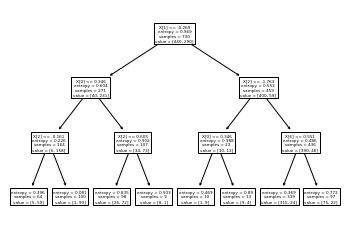

In [394]:
tree.plot_tree(_arvore)

In [395]:
previsoes_arvore = arvore.predict(x_teste)
previsoes_arvore

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,

In [396]:
y_teste

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [397]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [398]:
print("Acurácia: %.2f%%" % (accuracy_score(y_teste, previsoes_arvore) * 100.0))

Acurácia: 81.79%


In [399]:
confusion_matrix(y_teste, previsoes_arvore)

array([[167,  21],
       [ 36,  89]])

In [400]:
print(classification_report(y_teste, previsoes_arvore))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       188
           1       0.81      0.71      0.76       125

    accuracy                           0.82       313
   macro avg       0.82      0.80      0.81       313
weighted avg       0.82      0.82      0.82       313



**Arvore com max_depth = 4**

In [401]:
arvore = DecisionTreeClassifier(criterion='entropy', random_state = 0, max_depth=4)
#arvore = DecisionTreeClassifier(criterion='entropy', random_state = 0)
_arvore = arvore.fit(x_treino, y_treino)

[Text(0.5, 0.9, 'X[1] <= -0.269\nentropy = 0.969\nsamples = 730\nvalue = [440, 290]'),
 Text(0.25, 0.7, 'X[0] <= 0.346\nentropy = 0.604\nsamples = 271\nvalue = [40, 231]'),
 Text(0.125, 0.5, 'X[2] <= -0.161\nentropy = 0.226\nsamples = 164\nvalue = [6, 158]'),
 Text(0.0625, 0.3, 'X[2] <= -0.44\nentropy = 0.396\nsamples = 64\nvalue = [5, 59]'),
 Text(0.03125, 0.1, 'entropy = 0.156\nsamples = 44\nvalue = [1, 43]'),
 Text(0.09375, 0.1, 'entropy = 0.722\nsamples = 20\nvalue = [4, 16]'),
 Text(0.1875, 0.3, 'X[5] <= -0.416\nentropy = 0.081\nsamples = 100\nvalue = [1, 99]'),
 Text(0.15625, 0.1, 'entropy = 0.439\nsamples = 11\nvalue = [1, 10]'),
 Text(0.21875, 0.1, 'entropy = 0.0\nsamples = 89\nvalue = [0, 89]'),
 Text(0.375, 0.5, 'X[2] <= 0.605\nentropy = 0.902\nsamples = 107\nvalue = [34, 73]'),
 Text(0.3125, 0.3, 'X[5] <= -0.243\nentropy = 0.835\nsamples = 98\nvalue = [26, 72]'),
 Text(0.28125, 0.1, 'entropy = 0.773\nsamples = 88\nvalue = [20, 68]'),
 Text(0.34375, 0.1, 'entropy = 0.971\nsam

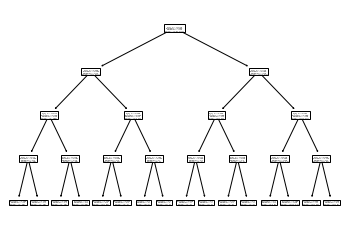

In [402]:
tree.plot_tree(_arvore)

In [403]:
previsoes_arvore = arvore.predict(x_teste)
previsoes_arvore

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [404]:
y_teste

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [405]:
print("Acurácia: %.2f%%" % (accuracy_score(y_teste, previsoes_arvore) * 100.0))

Acurácia: 83.39%


**Arvore com max_depth = 5**

In [406]:
arvore = DecisionTreeClassifier(criterion='entropy', random_state = 0, max_depth=5)
#arvore = DecisionTreeClassifier(criterion='entropy', random_state = 0)
_arvore = arvore.fit(x_treino, y_treino)

[Text(0.5085227272727273, 0.9166666666666666, 'X[1] <= -0.269\nentropy = 0.969\nsamples = 730\nvalue = [440, 290]'),
 Text(0.29545454545454547, 0.75, 'X[0] <= 0.346\nentropy = 0.604\nsamples = 271\nvalue = [40, 231]'),
 Text(0.17045454545454544, 0.5833333333333334, 'X[2] <= -0.161\nentropy = 0.226\nsamples = 164\nvalue = [6, 158]'),
 Text(0.09090909090909091, 0.4166666666666667, 'X[2] <= -0.44\nentropy = 0.396\nsamples = 64\nvalue = [5, 59]'),
 Text(0.045454545454545456, 0.25, 'X[2] <= -1.902\nentropy = 0.156\nsamples = 44\nvalue = [1, 43]'),
 Text(0.022727272727272728, 0.08333333333333333, 'entropy = 0.918\nsamples = 3\nvalue = [1, 2]'),
 Text(0.06818181818181818, 0.08333333333333333, 'entropy = 0.0\nsamples = 41\nvalue = [0, 41]'),
 Text(0.13636363636363635, 0.25, 'X[5] <= -0.181\nentropy = 0.722\nsamples = 20\nvalue = [4, 16]'),
 Text(0.11363636363636363, 0.08333333333333333, 'entropy = 0.918\nsamples = 9\nvalue = [3, 6]'),
 Text(0.1590909090909091, 0.08333333333333333, 'entropy = 0

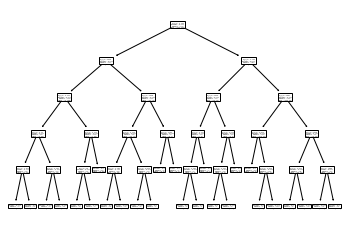

In [407]:
tree.plot_tree(_arvore)

In [408]:
previsoes_arvore = arvore.predict(x_teste)
previsoes_arvore

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,

In [409]:
y_teste

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [410]:
print("Acurácia: %.2f%%" % (accuracy_score(y_teste, previsoes_arvore) * 100.0))

Acurácia: 83.07%


**Arvore com max_depth = 6**

In [411]:
arvore = DecisionTreeClassifier(criterion='entropy', random_state = 0, max_depth=6)
#arvore = DecisionTreeClassifier(criterion='entropy', random_state = 0)
_arvore = arvore.fit(x_treino, y_treino)

[Text(0.5232843137254902, 0.9285714285714286, 'X[1] <= -0.269\nentropy = 0.969\nsamples = 730\nvalue = [440, 290]'),
 Text(0.32107843137254904, 0.7857142857142857, 'X[0] <= 0.346\nentropy = 0.604\nsamples = 271\nvalue = [40, 231]'),
 Text(0.19117647058823528, 0.6428571428571429, 'X[2] <= -0.161\nentropy = 0.226\nsamples = 164\nvalue = [6, 158]'),
 Text(0.10784313725490197, 0.5, 'X[2] <= -0.44\nentropy = 0.396\nsamples = 64\nvalue = [5, 59]'),
 Text(0.058823529411764705, 0.35714285714285715, 'X[2] <= -1.902\nentropy = 0.156\nsamples = 44\nvalue = [1, 43]'),
 Text(0.0392156862745098, 0.21428571428571427, 'X[6] <= 0.551\nentropy = 0.918\nsamples = 3\nvalue = [1, 2]'),
 Text(0.0196078431372549, 0.07142857142857142, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.058823529411764705, 0.07142857142857142, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.0784313725490196, 0.21428571428571427, 'entropy = 0.0\nsamples = 41\nvalue = [0, 41]'),
 Text(0.1568627450980392, 0.357142857142

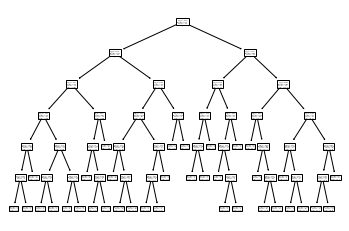

In [412]:
tree.plot_tree(_arvore)

In [413]:
previsoes_arvore = arvore.predict(x_teste)
previsoes_arvore

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,

In [414]:
y_teste

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [415]:
print("Acurácia: %.2f%%" % (accuracy_score(y_teste, previsoes_arvore) * 100.0))

Acurácia: 82.43%


*Chegamos a uma melhor acuracia usando o max_depth = 4*

*O Resultado foi de 83,49%*

**Análise dados de treino**

In [416]:
previsoes_treino = arvore.predict(x_treino)
previsoes_treino

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,

In [417]:
accuracy_score(y_treino, previsoes_treino)

0.9013698630136986

In [418]:
confusion_matrix(y_treino, previsoes_treino)

array([[418,  22],
       [ 50, 240]])

## Random Forest

In [419]:
from sklearn.ensemble import RandomForestClassifier

In [420]:
random = RandomForestClassifier(n_estimators=150, criterion='entropy', random_state = 0, max_depth=4)
random.fit(x_treino, y_treino)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=150,
                       random_state=0)

In [421]:
previsoes_random = random.predict(x_teste)
previsoes_random

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,

In [422]:
y_teste

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [423]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [424]:
print("Acurácia: %.2f%%" % (accuracy_score(y_teste, previsoes_random) * 100.0))

Acurácia: 82.43%


In [425]:
confusion_matrix(y_teste, previsoes_random)

array([[166,  22],
       [ 33,  92]])

In [426]:
print(classification_report(y_teste, previsoes_random))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       188
           1       0.81      0.74      0.77       125

    accuracy                           0.82       313
   macro avg       0.82      0.81      0.81       313
weighted avg       0.82      0.82      0.82       313



**Análise dados de treino**

In [427]:
previsoes_treino = random.predict(x_treino)
previsoes_treino

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,

In [428]:
accuracy_score(y_treino, previsoes_treino)

0.8849315068493151

In [429]:
confusion_matrix(y_treino, previsoes_treino)

array([[408,  32],
       [ 52, 238]])

## Regressão Logística

In [430]:
from sklearn.linear_model import LogisticRegression

In [431]:
logistica = LogisticRegression(random_state=1, max_iter=500, penalty="l2",
                               tol=0.0001, C=2,solver="lbfgs")
logistica.fit(x_treino, y_treino)

LogisticRegression(C=2, max_iter=500, random_state=1)

In [432]:
logistica.intercept_

array([-0.63021061])

In [433]:
logistica.coef_

array([[-0.63334101, -1.92024288, -0.67172993, -0.19735792, -0.13693003,
         0.1143726 ,  0.3640106 ]])

In [434]:
previsoes_logistica = logistica.predict(x_teste)
previsoes_logistica

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,

In [435]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [436]:
print("Acurácia: %.2f%%" % (accuracy_score(y_teste, previsoes_logistica) * 100.0))

Acurácia: 81.47%


In [437]:
confusion_matrix(y_teste, previsoes_logistica)

array([[163,  25],
       [ 33,  92]])

In [438]:
print(classification_report(y_teste, previsoes_logistica))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       188
           1       0.79      0.74      0.76       125

    accuracy                           0.81       313
   macro avg       0.81      0.80      0.80       313
weighted avg       0.81      0.81      0.81       313



**Analise dados de treino**


In [439]:
previsoes_treino = logistica.predict(x_treino)
previsoes_treino

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,

In [440]:
accuracy_score(y_treino, previsoes_treino)

0.8698630136986302

In [441]:
confusion_matrix(y_treino, previsoes_treino)

array([[402,  38],
       [ 57, 233]])

Regressão Logística = 81,47%